In [1]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
from bilby.core.utils import random
from bilby.core.prior import Uniform, DeltaFunction

random.seed(123)

In [2]:
#Reproduce Fig 1 of https://arxiv.org/abs/2006.04396

# Setup
outdir = "outdir"
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)
label = "exp_damped_sinusoids"

sampling_frequency = 8192  # Hz
time_duration = 0.125 

#parameter arrays, taken from priors in Appendix B and posteriors in Appendix C of https://arxiv.org/abs/2006.04396
T = [1e-2, 1e-2, 1e-2]
f = [3357, 2579, 1500] #1500 fabricated from priors
alpha = [-1.6, -3.3, -2.5] #-2.5 fabricated from priors
psi = [-np.pi/2, 0, np.pi/2]

injection_parameters = dict(
    #taken from priors in Appendix B and posteriors in Appendix C of https://arxiv.org/abs/2006.04396
    H = 1e-20, 
    w_0 = 0.4,
    w_1 = 0.4,

    ra=0,
    dec=0,
    psi=0,
    geocent_time=0.0,
)

for j in [0, 1, 2]:
    injection_parameters |= {
        f"T_{j}": T[j],
        f"f_{j}": f[j],
        f"alpha_{j}": alpha[j],
        f"psi_{j}": psi[j],
    }

def exp_damped_sinusoids_model(time, H, 
          w_0, w_1,
          T_0, T_1, T_2,
          f_0, f_1, f_2,
          alpha_0, alpha_1, alpha_2,
          psi_0, psi_1, psi_2):
    
    w_2 = 1.0 - w_0 - w_1
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))
    tidx = time >= 0 #mask away anything negative

    for w, T, f, alpha, psi in [
        (w_0, T_0, f_0, alpha_0, psi_0),
        (w_1, T_1, f_1, alpha_1, psi_1),
        (w_2, T_2, f_2, alpha_2, psi_2)
    ]:
        h_plus[tidx] += H * w * np.exp(-time[tidx] / T) * np.cos(2 * np.pi * f * time[tidx] * (1 + alpha * time[tidx]) + psi)

    return dict (plus=h_plus, cross=h_cross) 

waveform_generator = bilby.gw.WaveformGenerator(
    duration=time_duration,
    start_time=injection_parameters["geocent_time"] - (time_duration / 2),
    sampling_frequency=sampling_frequency,
    time_domain_source_model=exp_damped_sinusoids_model,
)

ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
# ifos = bilby.gw.detector.InterferometerList(["CE", "H1", "ET"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=time_duration,
    start_time=injection_parameters["geocent_time"] - (time_duration / 2)
    
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
)

14:43 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.125, sampling_frequency=8192, start_time=-0.0625, frequency_domain_source_model=None, time_domain_source_model=__main__.exp_damped_sinusoids_model, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
14:43 bilby INFO    : Generation of mass parameters failed with message 'mass_1'
14:43 bilby INFO    : Generation of spin parameters failed with message 'spin_1z'
14:43 bilby INFO    : Generation of source frame parameters failed with message 'luminosity_distance'
14:43 bilby INFO    : Injected signal in H1:
14:43 bilby INFO    :   optimal SNR = 9.11
14:43 bilby INFO    :   matched filter SNR = 9.57-1.59j
14:43 bilby INFO    :   H = 1e-20
14:43 bilby INFO    :   w_0 = 0.4
14:43 bilby INFO    :   w_1 = 0.4
14:43 bilby INFO    :   ra = 0
14:43 bilby INFO    :   dec = 0
14:43 bilby INFO    :   psi = 0
14:43 bilby INFO    :   geocent_time = 0.0
14:43 bilb

[{'plus': array([ 1.29211808e-25+0.00000000e+00j, -1.28860706e-25-1.09226247e-27j,
          1.29191013e-25+2.18481275e-27j, -1.28818797e-25-3.27699950e-27j,
          1.29128597e-25+4.37005503e-27j, -1.28734915e-25-5.46237305e-27j,
          1.29024464e-25+6.55615685e-27j, -1.28608930e-25-7.64880817e-27j,
          1.28878456e-25+8.74354917e-27j, -1.28440649e-25-9.83673102e-27j,
          1.28690352e-25+1.09326644e-26j, -1.28229813e-25-1.20265693e-26j,
          1.28459864e-25+1.31239370e-26j, -1.27976096e-25-1.42187526e-26j,
          1.28186638e-25+1.53178038e-26j, -1.27679103e-25-1.64137132e-26j,
          1.27870256e-25+1.75147044e-26j, -1.27338372e-25-1.86118859e-26j,
          1.27510229e-25+1.97150822e-26j, -1.26953369e-25-2.08137090e-26j,
          1.27105997e-25+2.19193844e-26j, -1.26523487e-25-2.30196248e-26j,
          1.26656929e-25+2.41280630e-26j, -1.26048044e-25-2.52300798e-26j,
          1.26162320e-25+2.63415747e-26j, -1.25526281e-25-2.74455251e-26j,
          1.25621

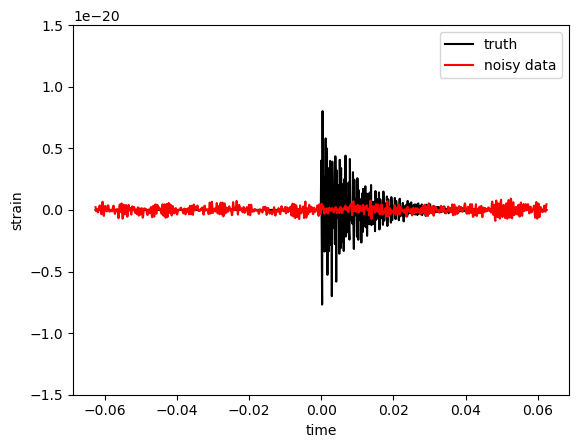

In [3]:
fig, ax = plt.subplots()

ax.plot(waveform_generator.time_array, waveform_generator.time_domain_strain(injection_parameters)['plus'], "k", label="truth")
ax.plot(waveform_generator.time_array, ifos[0].time_domain_strain, "r", label="noisy data")

# ax.set_xlim(0, 0.025)
ax.set_ylim(-1.5e-20, 1.5e-20)
ax.set_xlabel("time")
ax.set_ylabel("strain")
ax.legend()

In [4]:
prior = injection_parameters.copy()
prior["f_0"] = bilby.core.prior.Uniform(1000, 5000)
prior["f_1"] = bilby.core.prior.Uniform(1000, 5000)
prior["alpha_0"] = bilby.core.prior.Uniform(-6, 6)
prior["alpha_1"] = bilby.core.prior.Uniform(-6, 6)
# prior["amplitude"] = bilby.core.prior.LogUniform(1e-23, 1e-21, r"$h_0$")

likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator
)

result = bilby.core.sampler.run_sampler(
    likelihood,
    prior,
    sampler="dynesty",
    npoints=500,
    walks=5,
    nact=3,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    result_class=bilby.gw.result.CBCResult,
)

14:43 bilby INFO    : Running for label 'exp_damped_sinusoids', output will be saved to 'outdir'
/Users/ved/miniforge3/envs/neutron/lib/python3.12/site-packages/bilby/gw/likelihood/base.py:1143: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import git_version, __version__
14:43 bilby INFO    : Using lal version 7.7.0
14:43 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.7.0;Id: ef36dfdf49181b9b376a867b55a14463783de545;;Builder: Adam Mercer <adam.mer

1it [00:00, ?it/s]

14:53 bilby INFO    : Written checkpoint file outdir/exp_damped_sinusoids_resume.pickle
15:04 bilby INFO    : Written checkpoint file outdir/exp_damped_sinusoids_resume.pickle
15:15 bilby INFO    : Written checkpoint file outdir/exp_damped_sinusoids_resume.pickle
15:17 bilby INFO    : Written checkpoint file outdir/exp_damped_sinusoids_resume.pickle
15:17 bilby INFO    : Rejection sampling nested samples to obtain 2384 posterior samples
15:17 bilby INFO    : Sampling time: 0:34:01.951360
15:17 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:17 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:17 bilby INFO    : Summary of results:
nsamples: 2384
ln_noise_evidence: -676.578
ln_evidence: -537.032 +/-  0.102
ln_ba

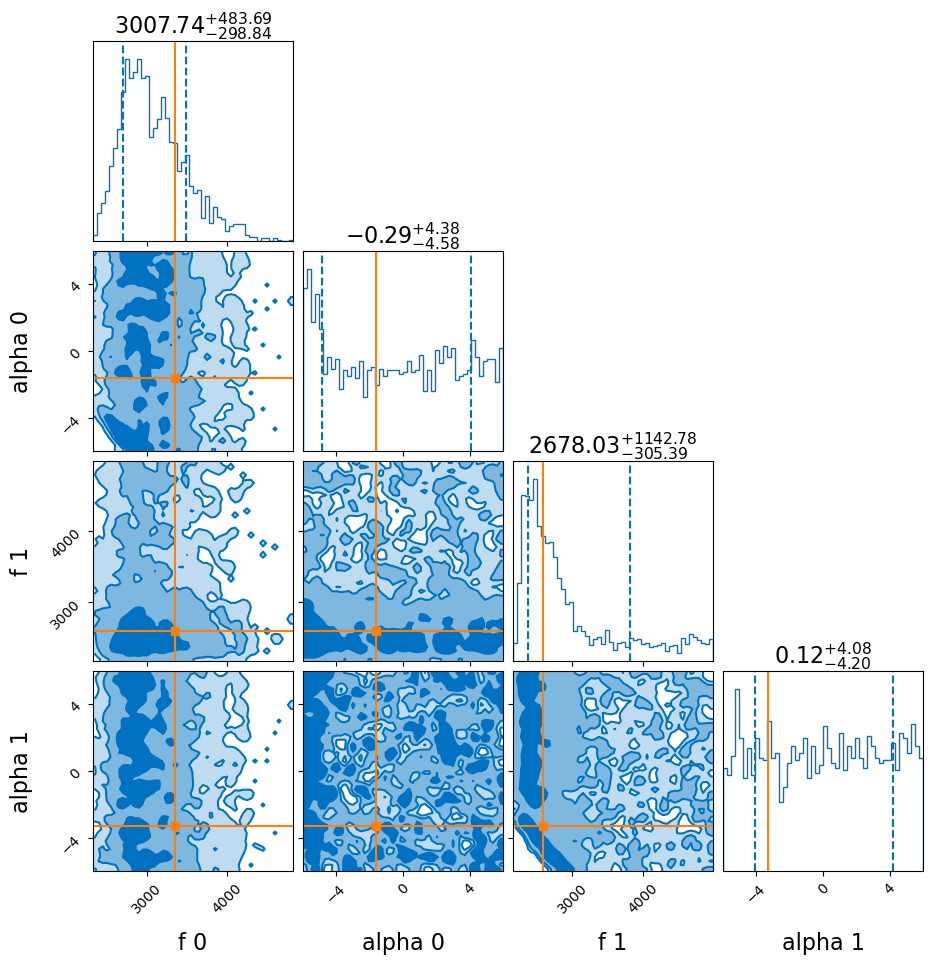

In [5]:
result.plot_corner(save=False)
plt.show()
plt.close()

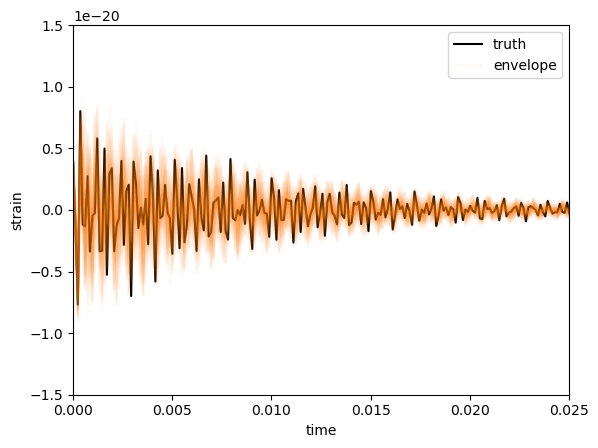

In [8]:
fig, ax = plt.subplots()

# ax.plot(time, ifos[0].time_domain_strain, "r", label="noisy data")
ax.plot(waveform_generator.time_array, waveform_generator.time_domain_strain(injection_parameters)['plus'], "k", label="truth")

for j,i in enumerate(np.random.choice(len(result.posterior), 50, replace=False)):
    sample = result.posterior.iloc[i]
    y_pred = exp_damped_sinusoids_model(waveform_generator.time_array, sample.H, 
          sample.w_0, sample.w_1,
          sample.T_0, sample.T_1, sample.T_2,
          sample.f_0, sample.f_1, sample.f_2,
          sample.alpha_0, sample.alpha_1, sample.alpha_2,
          sample.psi_0, sample.psi_1, sample.psi_2)
    # print(sample)
    
    ax.plot(waveform_generator.time_array, y_pred['plus'], color='C1', alpha=0.04, label="envelope" if j==0 else None)

ax.set_xlim(0, 0.025)
ax.set_ylim(-1.5e-20, 1.5e-20)
ax.set_xlabel("time")
ax.set_ylabel("strain")
ax.legend()

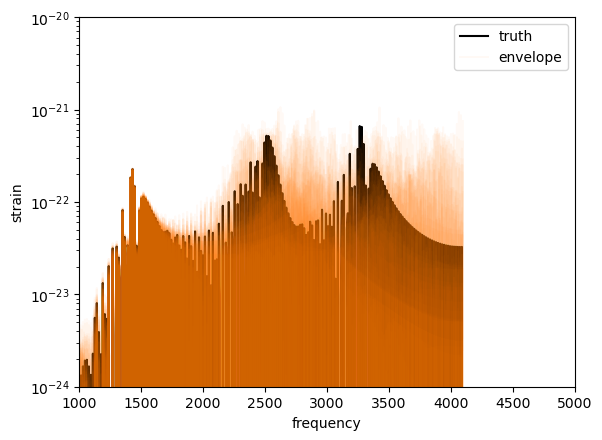

In [10]:
fig, ax = plt.subplots()

# ax.plot(ifos[0].frequency_array, ifos[0].frequency_domain_strain, "r", label="noisy data")
sqrt_f = np.sqrt(ifos[0].frequency_array)

ax.plot(ifos[0].frequency_array, waveform_generator.frequency_domain_strain(injection_parameters)['plus'] * sqrt_f, "k", label="truth")


parameter_keys = [
    'H', 'w_0', 'w_1', 'ra', 'dec', 'geocent_time', 'psi',
    'T_0', 'f_0', 'alpha_0', 'psi_0',
    'T_1', 'f_1', 'alpha_1', 'psi_1',
    'T_2', 'f_2', 'alpha_2', 'psi_2'
]

for j,i in enumerate(np.random.choice(len(result.posterior), 50, replace=False)):
    sample = result.posterior.iloc[i]
    sample_parameters = {k: sample[k] for k in parameter_keys}
    y_pred = waveform_generator.frequency_domain_strain(sample_parameters)['plus']
    
    ax.plot(ifos[0].frequency_array, y_pred * sqrt_f, color='C1', alpha=0.04, label="envelope" if j==0 else None)

ax.set_xlim(1000, 5000)
ax.set_ylim(1e-24, 1e-20)
ax.set_yscale('log')
ax.set_xlabel("frequency")
ax.set_ylabel("strain")
ax.legend()